In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import zfits
from tqdm import tqdm, trange

In [2]:
def trigger_period_as_series(path, start_event=0, number_of_events=None):
    #using just board time of board zero, to get a "feeling"
    f = zfits.ZFits(path)
    if number_of_events is None:
        number_of_events = f[2].get_nrows() - start_event

    bts = []
    for i in trange(start_event, start_event+number_of_events):
        bt = f.get("Events", "BoardTime", i)[0]
        bts.append(bt)
    bts = np.array(bts)
    
    # time unit is 100us .. so devide by 10 to get ms
    return pd.Series(np.diff(bts)) / 10.

In [3]:
class RunningStats():
    def __init__(self, shape=1):
        self.shape = shape
        self._n = np.zeros(shape, dtype=int)
        self._mean = np.full(shape, np.nan)
        self._M2 = np.full(shape, np.nan)

    def add(self, data):
        data = np.array(data, copy=False)

        idx = np.logical_not(np.isnan(data))
        uninitialised = np.logical_and(idx, self._n == 0)

        self._mean[uninitialised] = 0
        self._M2[uninitialised] = 0
        self._n[idx] += 1

        delta = data[idx] - self._mean[idx]
        self._mean[idx] += delta / self._n[idx]
        self._M2[idx] += delta * (data[idx] - self._mean[idx])

    @property
    def n(self):
        return self._n

    @property
    def mean(self):
        return self._mean

    @property
    def var(self):
        var = self._M2 / (self.n - 1)
        var[self.n <= 2] = np.nan
        return var

    @property
    def std(self):
        return np.sqrt(self.var)

    @property
    def sem(self):
        return 1 / np.sqrt(self.n) * self.std

In [4]:
def cell_offset(path, pixel_id, start_event=0, number_of_events=None):
    f = zfits.ZFits(path)
    if number_of_events is None:
        number_of_events = f[2].get_nrows() - start_event
    d = f.get_raw_data(0)[pixel_id]
    ds = RunningStats(d.shape)
    for i in trange(start_event, start_event+number_of_events):
        ds.add(f.get_raw_data(i, rolled=True)[pixel_id])
    return ds


In [5]:
def trigger_offset(path, pixel_id, celloffset=None, start_event=0, number_of_events=None):
    f = zfits.ZFits(path)
    if number_of_events is None:
        number_of_events = f[2].get_nrows() - start_event
    a = f.get_raw_data(0)[pixel_id]
    foo = RunningStats(a.shape)
    for i in trange(start_event, start_event+number_of_events):
        a = f.get_raw_data(i)[pixel_id]
        sc = f.get("Events", "StartCellData", i)[pixel_id]
        a -= celloffset[sc:sc+a.size]
        foo.add(a)
    return foo

In [6]:
ls raw/

20150410_054.fits.fz      20170306_048.fits.fz   20170306_051.fits.fz
20150410_055.fits.fz      20170306_050.drs.fits  20170306_057.fits.fz
20170306_048.drs.fits.gz  20170306_050.fits.fz   20170306_058.fits.fz


In [7]:
pixel_id = 527

In [8]:
o = cell_offset('raw/20170306_048.fits.fz', pixel_id, 0, 500).mean.round().astype('i2')
o2 = np.concatenate((o,o))

100%|██████████| 500/500 [00:22<00:00, 21.87it/s]


In [9]:
cs = trigger_offset(
    path='raw/20170306_048.fits.fz', 
    pixel_id=pixel_id, 
    celloffset=o2, 
    start_event=500)

100%|██████████| 500/500 [00:16<00:00, 30.27it/s]


In [10]:
D = [
    ('raw/20170306_050.fits.fz', 5),
    ('raw/20170306_051.fits.fz', 5),
    ('raw/20170306_057.fits.fz', 5),
    ('raw/20150410_054.fits.fz', 40),
    ('raw/20150410_055.fits.fz', 40),
]
E = []
for path, period in D:
    to = trigger_offset(path, pixel_id, o2)
    E.append((path, period, np.copy(to)))

100%|██████████| 1000/1000 [00:26<00:00, 37.78it/s]


In [14]:
F = 'raw/20170306_058.fits.fz', 5, trigger_offset('raw/20170306_058.fits.fz', pixel_id, o2, number_of_events=1000)

100%|██████████| 1000/1000 [00:27<00:00, 37.00it/s]


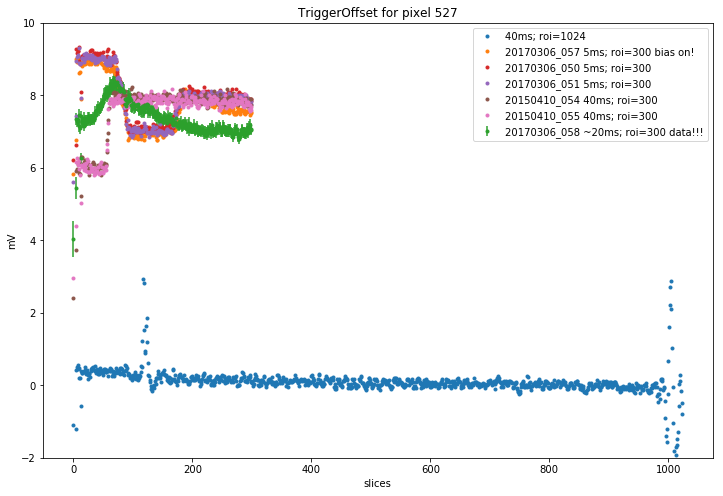

In [12]:
plt.figure(figsize=(12, 8))

plt.plot(cs.mean / 2., '.', label="40ms; roi=1024")

path, period, to = E[2]
to = to[()]
plt.plot(
    to.mean / 2., 
    '.', 
    label="{0} {1}ms; roi=300 bias on!".format(
        path[4:-8], 
        period)
)

path, period, to = F
plt.errorbar(
    x=np.arange(to.shape[0]),
    y=to.mean / 2., 
    yerr=to.std/ (2*np.sqrt(to.n)),
    fmt='.', 
    label="{0} ~{1}ms; roi=300 data!!!".format(
        path[4:-8], 
        20)
)


for path, period, to in E[0:2]+E[3:]:
    to = to[()]
    plt.plot(
        to.mean / 2., 
        '.', 
        label="{0} {1}ms; roi=300".format(
            path[4:-8], 
            period)
    )

plt.legend(loc='upper right')
plt.ylim(-2, 10)
#plt.xlim(0,1500)
plt.title("TriggerOffset for pixel 527")
plt.ylabel("mV")
plt.xlabel("slices")
None

In [13]:
trigger_period_as_series('raw/20170306_058.fits.fz', number_of_events=1000).describe()

100%|██████████| 1000/1000 [00:05<00:00, 181.08it/s]


count    999.000000
mean      24.946747
std       24.997165
min        0.300000
25%        6.550000
50%       17.700000
75%       35.750000
max      184.200000
dtype: float64